<a href="https://colab.research.google.com/github/ashrafulwork/TrafficVisionBD/blob/main/TrafficVisionBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#First we need to setup our envrionment before we even start training our model

In [1]:
!nvidia-smi

Tue Nov 12 12:01:37 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Installing kaggle

In [2]:
!pip install kaggle

Uploading kaggle.json file ( make sure to upload your own json file)

In [3]:
from google.colab import files
files.upload()  # This will prompt you to upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdashrafulhossain","key":"acc5ad91a973f1b6ab7b3cfd1f6eff38"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Here we passed the dataset path/link

In [5]:
!kaggle datasets download -d hasibzunair/rsud20k-bangladesh-road-scene-understanding # Replace 'datasetname' with your dataset's identifier


Dataset URL: https://www.kaggle.com/datasets/hasibzunair/rsud20k-bangladesh-road-scene-understanding
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
100% 10.2G/10.2G [02:38<00:00, 71.0MB/s]
100% 10.2G/10.2G [02:38<00:00, 69.1MB/s]


The dataset is now uploaded as a ZIP file. Now we need to upload/extract the zip file

In [6]:
import zipfile
import os

# Assuming the dataset is in a single zip file, e.g., 'datasetname.zip'
with zipfile.ZipFile("rsud20k-bangladesh-road-scene-understanding.zip", 'r') as zip_ref:
    zip_ref.extractall("path/to/extract")  # Replace with your preferred directory


# Data Analysis and exploration starts

Now let us see some samples of our dataset

Found 20334 images belonging to 2 classes.


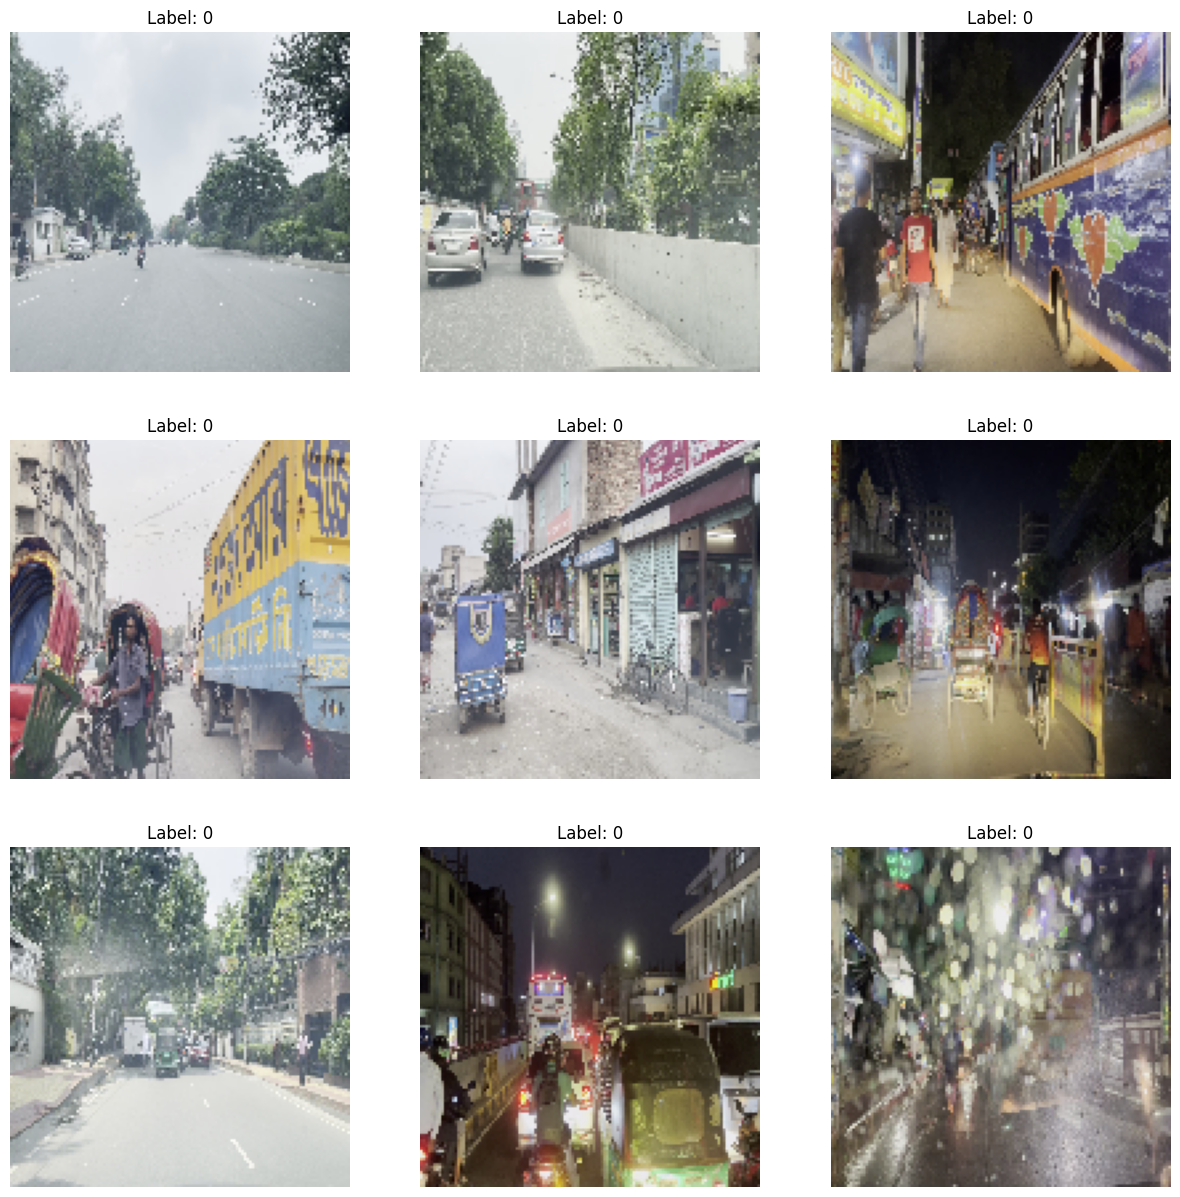

In [26]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Set up ImageDataGenerator to load images with labels
data_dir = '/content/path/to/extract/rsud20k'  # Replace with the path where images are extracted

# Load images directly from the directory
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
data = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),  # Resize images to 128x128 (adjust as needed)
    batch_size=32,
    class_mode='binary'  # Change to 'categorical' if you have more than 2 classes
)

# Display a batch of images
def show_images(images, labels):
    plt.figure(figsize=(15, 15))
    for i in range(9):  # Display 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.show()

# Get a batch of images and labels
images, labels = next(data)
show_images(images, labels)


Classes found: ['val', 'test', 'train']
Class 'val': 1004 images
Class 'test': 649 images
Class 'train': 18681 images


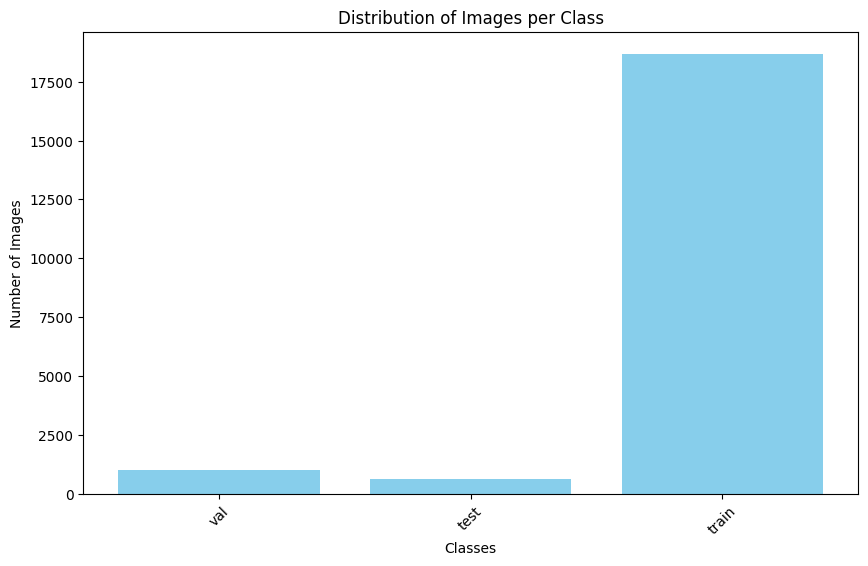

In [27]:
import os
import matplotlib.pyplot as plt

# Define the path to your dataset
dataset_path = '/content/path/to/extract/rsud20k/images'  # Change this to the path of your dataset

# Initialize an empty dictionary to store image counts per class
class_counts = {}
# Check if the path exists
if not os.path.exists(dataset_path):
    print("Dataset path does not exist.")
else:
    # List the directories within the dataset path
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print("Classes found:", classes)

    # Iterate over each class folder and count images
    for class_name in classes:
        class_folder = os.path.join(dataset_path, class_name)
        image_count = len([img for img in os.listdir(class_folder) if img.endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = image_count
        print(f"Class '{class_name}': {image_count} images")

# If no classes are found, show a message
if not class_counts:
    print("No images found in the specified path.")
else:
    # Convert the dictionary to lists for plotting
    class_names = list(class_counts.keys())
    image_counts = list(class_counts.values())

    # Plotting the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(class_names, image_counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Distribution of Images per Class')
    plt.xticks(rotation=45)
    plt.show()


In [28]:
import os
import hashlib
from PIL import Image

# Define the path to your dataset
dataset_path = '/content/path/to/extract/rsud20k'  # Change this to the path of your dataset

# Initialize dictionaries to store image hashes and track duplicates
image_hashes = {}
duplicates = []
corrupt_images = []

# Function to calculate the hash of an image
def calculate_hash(image_path):
    with open(image_path, 'rb') as f:
        img_hash = hashlib.md5(f.read()).hexdigest()
    return img_hash

# Loop through each class folder and each image
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)

            # Check for corrupt images
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Verify that the image is valid
            except (IOError, SyntaxError) as e:
                print(f"Corrupt image detected: {image_path}")
                corrupt_images.append(image_path)
                continue

            # Calculate hash for duplicate detection
            img_hash = calculate_hash(image_path)
            if img_hash in image_hashes:
                print(f"Duplicate image found: {image_path} and {image_hashes[img_hash]}")
                duplicates.append((image_path, image_hashes[img_hash]))
            else:
                image_hashes[img_hash] = image_path

# Summary of issues
print("\nSummary of Issues:")
print(f"Total duplicate images: {len(duplicates)}")
for dup1, dup2 in duplicates:
    print(f"Duplicate pair: {dup1}, {dup2}")

print(f"Total corrupt images: {len(corrupt_images)}")
for corrupt in corrupt_images:
    print(f"Corrupt image: {corrupt}")



Summary of Issues:
Total duplicate images: 0
Total corrupt images: 0


In [30]:
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np

# Define paths
images_path = "/content/path/to/extract/rsud20k/images/train"  # Update this path
labels_path = "/content/path/to/extract/rsud20k/labels/train"  # Update this path

# Load class names (assuming a file with names or define them manually)
class_names = ["person", "rickshaw", "rickshaw van", "auto rickshaw","truck " ,"pickup truck" ,"private car" ,"motorcycle" ,"bicycle" ,"bicycle" ,"micro bus" ,"covered van" ,"covered van"]  # Update according to your dataset


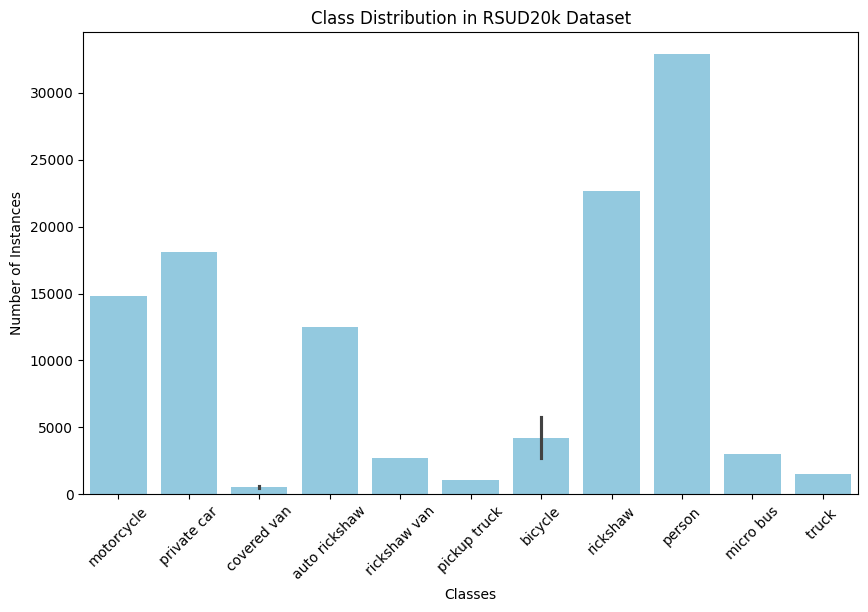

In [31]:
from collections import Counter

# Count occurrences of each class in labels
class_counts = Counter()

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            class_id = int(line.split()[0])
            class_counts[class_id] += 1

# Plot class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=[class_names[c] for c in class_counts.keys()], y=list(class_counts.values()), color="skyblue")
plt.xlabel("Classes")
plt.ylabel("Number of Instances")
plt.title("Class Distribution in RSUD20k Dataset")
plt.xticks(rotation=45)
plt.show()


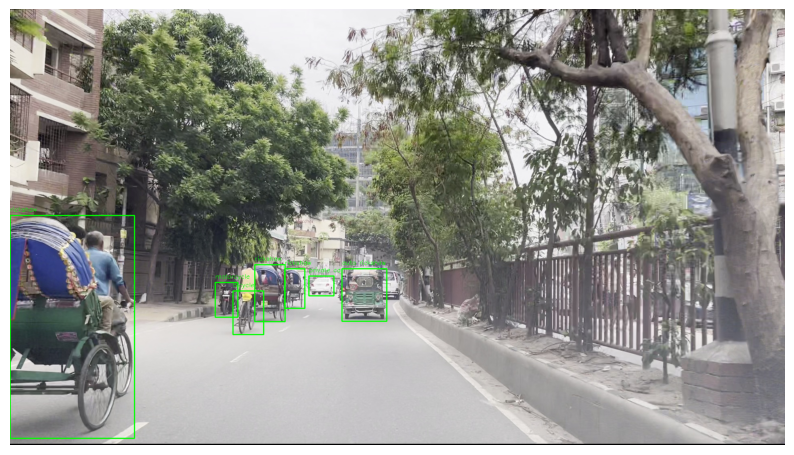

In [33]:
def plot_image_with_bboxes(image_path, label_path):
    image = cv2.imread(image_path)
    h, w, _ = image.shape

    with open(label_path, 'r') as f:
        for line in f:
            class_id, cx, cy, bw, bh = map(float, line.strip().split())
            x1 = int((cx - bw / 2) * w)
            y1 = int((cy - bh / 2) * h)
            x2 = int((cx + bw / 2) * w)
            y2 = int((cy + bh / 2) * h)

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, class_names[int(class_id)], (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Example visualization
sample_image = os.path.join(images_path, "/content/path/to/extract/rsud20k/images/train/train0.jpg")  # Update with a sample image
sample_label = os.path.join(labels_path, "/content/path/to/extract/rsud20k/labels/train/train0.txt")   # Update with the corresponding label
plot_image_with_bboxes(sample_image, sample_label)


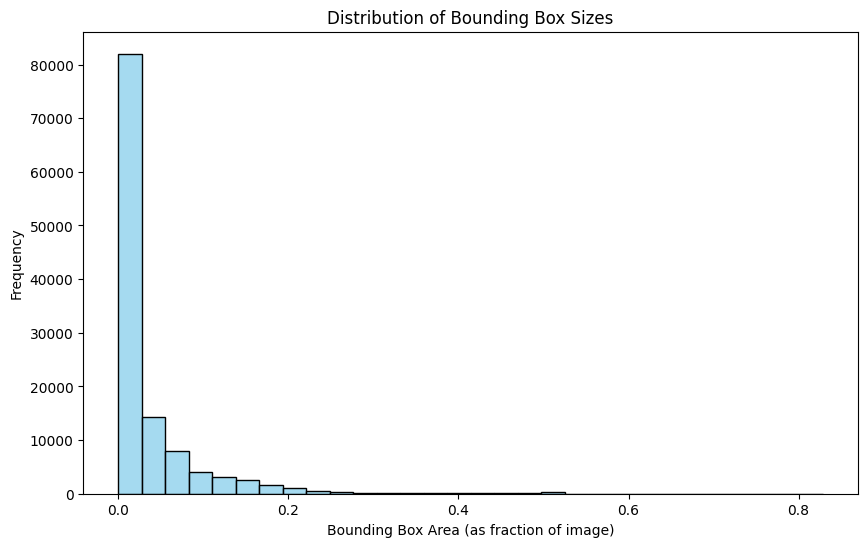

In [34]:
box_areas = []

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            _, _, _, bw, bh = map(float, line.strip().split())
            box_areas.append(bw * bh)

plt.figure(figsize=(10, 6))
sns.histplot(box_areas, bins=30, color='skyblue')
plt.xlabel("Bounding Box Area (as fraction of image)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Sizes")
plt.show()


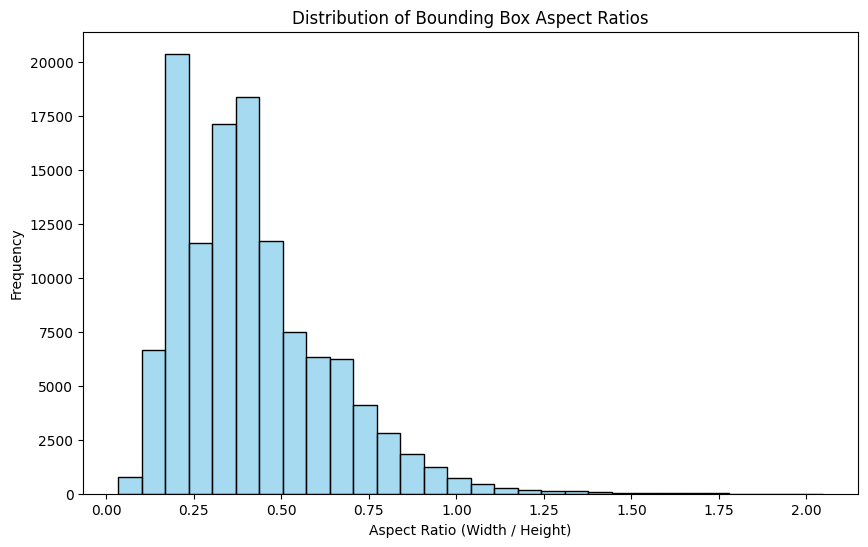

In [35]:
aspect_ratios = []

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        for line in f:
            _, _, _, bw, bh = map(float, line.strip().split())
            aspect_ratios.append(bw / bh)

plt.figure(figsize=(10, 6))
sns.histplot(aspect_ratios, bins=30, color='skyblue')
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Distribution of Bounding Box Aspect Ratios")
plt.show()


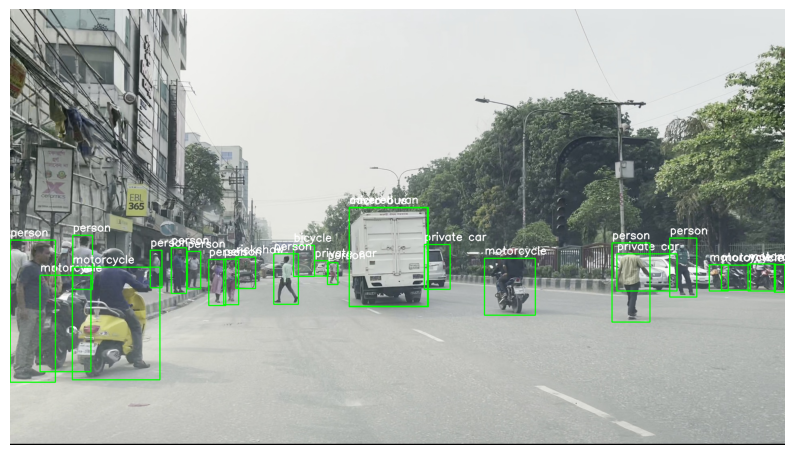

Image with most bounding boxes: train5171.txt with 25 boxes


In [43]:
import cv2
import matplotlib.pyplot as plt

# Define the list of class names
class_names = [
    "person", "rickshaw", "rickshaw van", "auto rickshaw", "truck",
    "pickup truck", "private car", "motorcycle", "bicycle", "bicycle",
    "micro bus", "covered van", "covered van"
]

# Ensure you are using OpenCV to read the image to retain its original quality
image = cv2.imread(image_path)  # Open image using OpenCV to maintain its quality
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for correct display in matplotlib

# Read and draw the bounding boxes from the label file
with open(label_path, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split()
        # Check if the label file has enough parts (label index + 4 bounding box parameters)
        if len(parts) >= 5:
            label_idx, x_center, y_center, width, height = map(float, parts[0:5])

            # Get the class name based on the label index from the class_names list
            label_name = class_names[int(label_idx)] if int(label_idx) < len(class_names) else 'unknown'  # Handle out-of-range index

            # Convert normalized coordinates to image pixel values
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])

            # Ensure the bounding box coordinates are within image boundaries
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image.shape[1] - 1, x_max)
            y_max = min(image.shape[0] - 1, y_max)

            # Draw the bounding box on the image (using a green box)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green box

            # Put the class label text above the bounding box
            cv2.putText(image, label_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 255), 2)

# Display the image with bounding boxes and labels using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')  # Hide axis
plt.show()

print(f"Image with most bounding boxes: {max_bboxes_image} with {max_bboxes} boxes")


Image with most bounding boxes: train5171.txt with 25 boxes


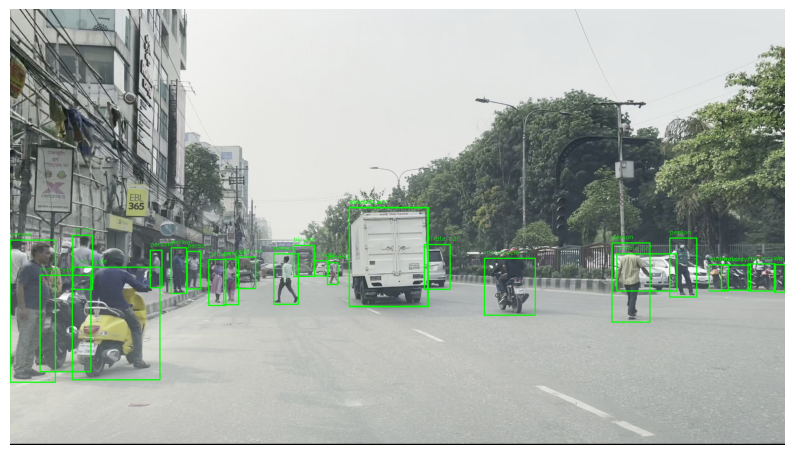

In [36]:
max_bboxes = 0
max_bboxes_image = ""

for label_file in os.listdir(labels_path):
    with open(os.path.join(labels_path, label_file), 'r') as f:
        bbox_count = len(f.readlines())
        if bbox_count > max_bboxes:
            max_bboxes = bbox_count
            max_bboxes_image = label_file

# Display the image with the most bounding boxes
image_path = os.path.join(images_path, max_bboxes_image.replace('.txt', '.jpg'))  # Update extension if needed
label_path = os.path.join(labels_path, max_bboxes_image)
print(f"Image with most bounding boxes: {max_bboxes_image} with {max_bboxes} boxes")
plot_image_with_bboxes(image_path, label_path)


In [ ]:
import os
print(os.path.exists("/content/image.png"))


In [ ]:
#checking maximum number of class

In [ ]:
import os

label_dir = '/content/path/to/extract/rsud20k/labels/train'  # Path to your label directory
classes_count = 13  # Total number of classes

# Function to fix the labels
def fix_labels(label_file):
    with open(label_file, 'r') as file:
        lines = file.readlines()

    corrected_lines = []
    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        if class_id >= classes_count:  # If class ID is greater than 12, we correct it
            print(f"Correcting label {line.strip()} in {label_file}")
            class_id = class_id % classes_count  # Assign a valid class ID
        corrected_line = f"{class_id} " + " ".join(parts[1:])
        corrected_lines.append(corrected_line)

    with open(label_file, 'w') as file:
        file.writelines([line + '\n' for line in corrected_lines])

# Iterate over label files and fix them
for label_file in os.listdir(label_dir):
    if label_file.endswith('.txt'):
        fix_labels(os.path.join(label_dir, label_file))


In [ ]:
import os

image_dir = '/content/path/to/extract/rsud20k/images/train'
label_dir = '/content/path/to/extract/rsud20k/labels/train'

# Check for missing or empty label files
missing_labels = []
empty_labels = []

for image_file in os.listdir(image_dir):
    if image_file.endswith('.jpg'):  # assuming your images are in JPG format
        label_file = image_file.replace('.jpg', '.txt')
        label_path = os.path.join(label_dir, label_file)

        if not os.path.exists(label_path):
            missing_labels.append(label_file)
        else:
            with open(label_path, 'r') as file:
                if len(file.readlines()) == 0:  # Empty label file
                    empty_labels.append(label_file)

print("Missing label files:", missing_labels)
print("Empty label files:", empty_labels)


Missing label files: []
Empty label files: []


# Main Body

In [ ]:
!pip install yolov10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.4/953.4 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 106.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 7.7 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=9f74fa749d90023a13de8313f83d6a1cedd727fbd5dd8e8af6dc5d388d29dade
  Stored in dire

In [ ]:
from ultralytics import YOLO
model = YOLO('yolov10n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.59M/5.59M [00:00<00:00, 86.4MB/s]


In [ ]:
results = model(source = "/content/path/to/extract/rsud20k/images/train/train0.jpg", show =True, conf =0.4, save = True)


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/path/to/extract/rsud20k/images/train/train0.jpg: 384x640 2 persons, 2 bicycles, 1 car, 122.7ms
Speed: 3.1ms preprocess, 122.7ms inference, 123.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


In [ ]:
from ultralytics import YOLO

model = YOLO('yolov10n.pt')



In [ ]:
!yolo task=detect mode=train model="/content/yolov10n.pt" data="/content/data.yaml" epochs=10 imgsz=640


Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/yolov10n.pt, data=/content/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_box

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov9t.pt')

100%|██████████| 4.74M/4.74M [00:00<00:00, 87.9MB/s]


In [ ]:
results = model(source = "/content/path/to/extract/rsud20k/images/train/train1003.jpg", show =True, conf =0.4, save = True)


WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()


image 1/1 /content/path/to/extract/rsud20k/images/train/train1003.jpg: 384x640 3 persons, 1 car, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict2


In [ ]:
!yolo predict model="/content/yolov9t.pt" source = "/content/mixed (101).jpg"

Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv9t summary (fused): 486 layers, 2,094,000 parameters, 0 gradients, 8.2 GFLOPs

image 1/1 /content/mixed (101).jpg: 480x640 3 persons, 1 bicycle, 1 motorcycle, 90.6ms
Speed: 5.5ms preprocess, 90.6ms inference, 972.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict5
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [ ]:
!yolo task=segment mode=predict model="/content/yolo11x-seg.pt" source = "/content/mixed (101).jpg"

100% 119M/119M [00:00<00:00, 265MB/s]
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11x-seg summary (fused): 491 layers, 62,094,528 parameters, 0 gradients, 319.0 GFLOPs

image 1/1 /content/mixed (101).jpg: 480x640 2 persons, 2 bicycles, 1 car, 1 motorcycle, 1 truck, 1 backpack, 111.5ms
Speed: 3.7ms preprocess, 111.5ms inference, 626.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict4
💡 Learn more at https://docs.ultralytics.com/modes/predict


DONT RUN THE BELOW CODES


In [ ]:
from google.colab import files

# Path to the trained model (best model or last model)
model_path = '/content/runs/detect/train11/weights/best.pt'  # or use 'last.pt' if you prefer

# Download the model
files.download(model_path)


FileNotFoundError: Cannot find file: /content/runs/detect/train11/weights/best.pt

In [ ]:
!yolo task=segment mode=predict model="/content/yolov8n-seg.pt" source = "/content/HHHHGG.mp4"

In [ ]:
from google.colab import files

# Path to the video file you want to download
video_path = '/content/runs/segment/predict6/HHHHGG.avi'

# Download the video file
files.download(video_path)


In [ ]:
!yolo predict model="/content/yolov8n.pt" source = "/content/HHHHGG.mp4"

In [ ]:
!pip freeze > requirements.txt